In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

1. Load Data

In [2]:
#load data
df = pd.read_csv('C:\\Git\\a3-predicting-car-price-Arun-vEDU\\Cars_a3.csv')

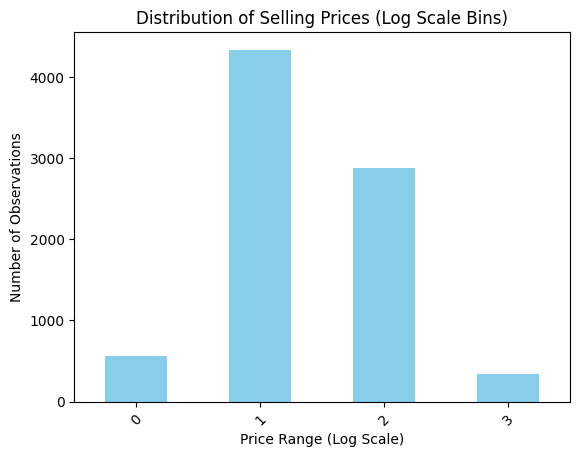

In [3]:
#Step 1: Prepare data
# y is simply the selling price colomn
y = df["selling_price"]

# Covert into log scale
y_log = np.log(df["selling_price"])


binned_data = pd.cut(y_log, bins=4, labels=False)  # Creates 0, 1, 2, 3
# plot the values
# Value counts for each bin
bin_counts = pd.value_counts(binned_data)

# Bar plot
bin_counts.sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Selling Prices (Log Scale Bins)')
plt.xlabel('Price Range (Log Scale)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.show()

In [4]:

# Step 2: Add binned_data as a new column in the DataFrame
df['binned_price'] = binned_data

# Step 3: Prepare features and labels
X = df.drop(columns=['selling_price', 'binned_price']) 
y = df['binned_price']  # Original binned labels (0, 1, 2, 3)

print(binned_data)

0       1
1       1
2       1
3       1
4       1
       ..
8123    1
8124    1
8125    1
8126    1
8127    1
Name: selling_price, Length: 8128, dtype: int64


In [5]:
# To check the data types of the columns
print(df.dtypes) 

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
binned_price       int64
dtype: object


In [6]:
# my selected features are 'Max Power' and 'Year' from a1 and a2 assignments.

# Split the 'max_power' column by space
df[['max_power', 'max_power_unit']] = df['max_power'].str.split(' ', expand=True)

# Remove the 'max_power_unit' column
df = df.drop('max_power_unit', axis=1)
df.columns

# Convert 'max_power' to a numeric type
df['max_power'] = pd.to_numeric(df['max_power'])

# To check the data types of the columns
#print(df)
print(df.dtypes)

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power        float64
torque            object
seats            float64
binned_price       int64
dtype: object


In [7]:
# Check the distribution of classes
class_distribution = binned_data.value_counts()

# Display the distribution of each class
print(class_distribution)

selling_price
1    4342
2    2884
0     565
3     337
Name: count, dtype: int64


In [8]:
# X is my selected strong features
# I have selected 2 features "year" and "max_power"
# less features are better.
X = df[        ['year', 'max_power']        ]

In [9]:
#Split the data into train and test
# test set is 20% of our dataset.
# This is a medium size data set, that is why it is selected 80%  traning set and 20% test set 

from sklearn.model_selection import train_test_split

#  X is your feature set and binned_data is your target (with 4 classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#check for null values in traning set,The .isna() method is used to detect missing values (not avalible) and count it
X_train[['year', 'max_power']].isna().sum()


year           0
max_power    167
dtype: int64

In [11]:
#check for null values in test set, and count it
X_test[['year', 'max_power']].isna().sum()

year          0
max_power    49
dtype: int64

In [12]:
# max power has 167 missing values. So we can fill them with ratio, the distribution of the 'max_power' is skewed.
# X_train is  training dataset and 'max_power' contains missing values

# Step 1: Calculate the ratio of each unique value in 'max_power'
ratio = X_train['max_power'].value_counts(normalize=True)

# Step 2: Define a function to sample values based on these ratios
def fill_missing_values(column, value_distribution):
    missing_indices = column[column.isnull()].index  # Find indices where values are missing
    filled_values = np.random.choice(value_distribution.index, 
                                     size=len(missing_indices), 
                                     p=value_distribution.values)  # Sample from distribution
    
    # Fill the missing values with sampled values
    column.loc[missing_indices] = filled_values
    return column

# Step 3: Fill missing values in 'max_power' based on the ratio
X_train['max_power'] = fill_missing_values(X_train['max_power'], ratio)

# Now, X_train['max_power'] has the missing values filled based on the value distribution
print(X_train['max_power'].isnull().sum())  # This should return 0 (no missing values)


0


In [13]:
# Step 4: Fill missing values in 'max_power' in X_test using the same ratio as X_train
X_test['max_power'] = fill_missing_values(X_test['max_power'], ratio)

# Now, X_test['max_power'] should have the missing values filled based on the distribution from X_train
print(X_test['max_power'].isnull().sum())  # This should also return 0 (no missing values)

0


In [14]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# Assuming y_train is already in label form (not one-hot encoded)
# No need to use idxmax if it's already a Series with labels
y_labels = y_train  # If y_train is already the labels (0, 1, 2, 3)

# Check the class distribution before SMOTE
print("Before SMOTE:", Counter(y_labels))  # Class distribution before SMOTE

# Now you can check the shapes again
print("Shape of X_train:", X_train.shape)
print("Shape of y_labels:", y_labels.shape)

# Proceed with SMOTE only after confirming the shapes match
smote = SMOTE(random_state=42)
X_train_smote, y_labels_smote = smote.fit_resample(X_train, y_labels)

# Check the class distribution after SMOTE
print("After SMOTE:", Counter(y_labels_smote))  # Class distribution after SMOTE


# One-hot encode y_labels_smote
y_labels_smote_one_hot = pd.get_dummies(y_labels_smote, prefix='class')

# Check the first few rows of one-hot encoded labels
print(y_labels_smote_one_hot.head())


Before SMOTE: Counter({1: 3443, 2: 2323, 0: 467, 3: 269})
Shape of X_train: (6502, 2)
Shape of y_labels: (6502,)
After SMOTE: Counter({1: 3443, 0: 3443, 2: 3443, 3: 3443})
   class_0  class_1  class_2  class_3
0    False     True    False    False
1    False     True    False    False
2    False     True    False    False
3    False     True    False    False
4    False     True    False    False


After SMOTE: Counter({1: 3443, 0: 3443, 2: 3443, 3: 3443})
   class_0  class_1  class_2  class_3
0    False     True    False    False
1    False     True    False    False
2    False     True    False    False
3    False     True    False    False
4    False     True    False    False
Shape of X_train_with_intercept: (13772, 3)
Shape of y_labels_smote_one_hot: (13772, 4)
Shape of X_test_with_intercept: (13772, 3)
Shape of y_labels_smote_one_hot: (13772, 4)
Shape of X_train_with_intercept: (13772, 3)
Shape of y_labels_smote_one_hot: (13772, 4)
X shape: (13772, 3)
W shape: (3, 4)
Loss at iteration 0: class_0    0.494005
class_1    0.339531
class_2    0.236451
class_3    0.542261
dtype: float64
X shape: (13772, 3)
W shape: (3, 4)
X shape: (13772, 3)
W shape: (3, 4)
X shape: (13772, 3)
W shape: (3, 4)
X shape: (13772, 3)
W shape: (3, 4)
X shape: (13772, 3)
W shape: (3, 4)
X shape: (13772, 3)
W shape: (3, 4)
X shape: (13772, 3)
W shape: (3, 4)
X shape: (13772, 3)
W shape: (3, 4)
X shape: (

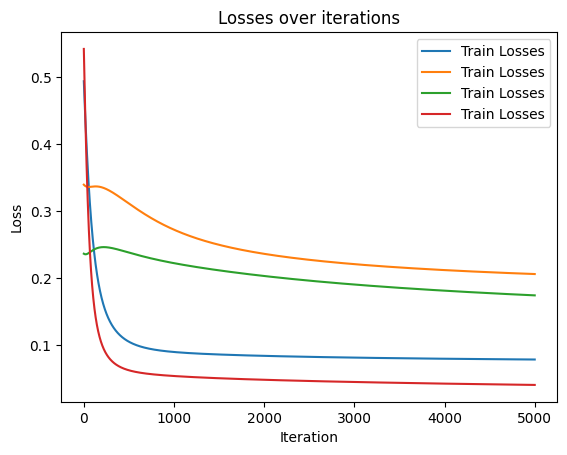

Accuracy: 0.6943
Macro Precision: 0.5971
Macro Recall: 0.8060
Macro F1 Score: 0.6479


In [15]:
# I'm running the custom class for one set of method = batch and one set of parameters to adjest the matrix indexies.
from collections import Counter
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Step 1: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scaled X_train
X_test_scaled = scaler.transform(X_test)        # Scaled X_test

y_labels = y_train  # If y_train is already the labels (0, 1, 2, 3)
# Step 2: Apply SMOTE to the scaled X_train
smote = SMOTE(random_state=42)
X_train_smote, y_labels_smote = smote.fit_resample(X_train_scaled, y_labels)  # Use the scaled X_train


# Check the class distribution after SMOTE
print("After SMOTE:", Counter(y_labels_smote))

# One-hot encode the labels
y_labels_smote_one_hot = pd.get_dummies(y_labels_smote, prefix='class')
print(y_labels_smote_one_hot.head())

# Step 3: Add intercept term AFTER SMOTE and scaling
intercept_train = np.ones((X_train_smote.shape[0], 1))  # Shape (m, 1)
X_train_with_intercept = np.concatenate((intercept_train, X_train_smote), axis=1)  # Shape (m, n + 1)

intercept_test = np.ones((X_test_scaled.shape[0], 1))  # Shape (m, 1)
X_test_with_intercept = np.concatenate((intercept_test, X_test_scaled), axis=1)  # Shape (m, n + 1)

# Check shapes
print("Shape of X_train_with_intercept:", X_train_with_intercept.shape)
print("Shape of y_labels_smote_one_hot:", y_labels_smote_one_hot.shape)
print("Shape of X_test_with_intercept:", X_train_with_intercept.shape)
print("Shape of y_labels_smote_one_hot:", y_labels_smote_one_hot.shape)


import numpy as np
import time
import matplotlib.pyplot as plt

class LogisticRegression:
    
    def __init__(self, k, n, method, alpha=0.01, max_iter=5000, use_penalty=False, penalty='ridge', lambda_=0.01):
        self.k = k  # Number of classes
        self.n = n  # Number of features
        self.alpha = alpha  # Learning rate
        self.max_iter = max_iter  # Maximum iterations
        self.method = method  # Optimization method: 'batch', 'minibatch', or 'sto'
        self.use_penalty = use_penalty  # Whether to use penalty (regularization)
        self.penalty = penalty  # Type of penalty ('ridge' for L2)
        self.lambda_ = lambda_  # Regularization strength
        self.W = np.random.rand(n + 1, k)  # Initialize weights

    def fit(self, X, Y):
        self.W = np.random.rand(self.n + 1, self.k)   # Initialize weights
        self.losses = []  # To store loss values
        
        if self.method == "batch":
            start_time = time.time()
            for i in range(self.max_iter):
                loss, grad = self.gradient(X, Y)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        elif self.method == "minibatch":
            start_time = time.time()
            batch_size = int(0.3 * X.shape[0])
            for i in range(self.max_iter):
                indices = np.random.choice(X.shape[0], size=batch_size, replace=False)  # Randomly select indices for the batch
                batch_X = X[indices]
                batch_Y = Y[indices]
                loss, grad = self.gradient(batch_X, batch_Y)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        elif self.method == "sto":
            start_time = time.time()
            for i in range(self.max_iter):
                idx = np.random.randint(X.shape[0])  # Randomly select an index
                X_train = X[idx, :].reshape(1, -1)  # Reshape for a single sample
                Y_train = Y[idx].reshape(1, -1)  # Reshape for a single sample
                loss, grad = self.gradient(X_train, Y_train)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        else:
            raise ValueError('Method must be one of the following: "batch", "minibatch", or "sto".')
        
    def gradient(self, X, Y):
        m = X.shape[0]  # Number of training examples
        h = self.h_theta(X, self.W)  # Hypothesis
        loss = -np.sum(Y * np.log(h)) / m  # Cross-entropy loss
        
        # Apply penalty if use_penalty is True
        if self.use_penalty and self.penalty == 'ridge':
            loss += (self.lambda_ / (2 * m)) * np.sum(np.square(self.W))  # Ridge penalty (L2)
        
        error = h - Y  # Error term
        grad = self.softmax_grad(X, error)
        
        # Apply gradient for penalty if use_penalty is True
        if self.use_penalty and self.penalty == 'ridge':
            grad += (self.lambda_ / m) * self.W  # Add Ridge gradient (L2)
        
        return loss, grad
        
    def softmax(self, theta_t_x):
            # Ensure input is a NumPy array
        theta_t_x = np.array(theta_t_x)
    
            #  Perform softmax calculation
        exp_values = np.exp(theta_t_x - np.max(theta_t_x, axis=1, keepdims=True))
            
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)
    
    #def softmax(self, theta_t_x):
       # return np.exp(theta_t_x - np.max(theta_t_x, axis=1, keepdims=True)) / np.sum(np.exp(theta_t_x - np.max(theta_t_x, axis=1, keepdims=True)), axis=1, keepdims=True)

    def softmax_grad(self, X, error):
        return X.T @ error / X.shape[0]

    def h_theta(self, X, W):
        print(f"X shape: {X.shape}")
        print(f"W shape: {W.shape}")
        return self.softmax(X @ W)

    def predict(self, X_test):
        return np.argmax(self.h_theta(X_test, self.W), axis=1)
    
    def plot(self):
        plt.plot(np.arange(len(self.losses)), self.losses, label="Train Losses")
        plt.title("Losses over iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
    
    def accuracy(self, y_true, y_pred):
        correct = np.sum(y_true == y_pred)
        total = len(y_true)
        return correct / total

    def precision(self, y_true, y_pred, class_label):
        TP = np.sum((y_true == class_label) & (y_pred == class_label))
        FP = np.sum((y_true != class_label) & (y_pred == class_label))
        return TP / (TP + FP) if (TP + FP) > 0 else 0

    def recall(self, y_true, y_pred, class_label):
        TP = np.sum((y_true == class_label) & (y_pred == class_label))
        FN = np.sum((y_true == class_label) & (y_pred != class_label))
        return TP / (TP + FN) if (TP + FN) > 0 else 0

    def f1_score(self, y_true, y_pred, class_label):
        prec = self.precision(y_true, y_pred, class_label)
        rec = self.recall(y_true, y_pred, class_label)
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    
    # New macro precision, recall, and f1 functions
    def macro_precision(self, y_true, y_pred):
        classes = np.unique(y_true)
        precision_scores = [self.precision(y_true, y_pred, class_label) for class_label in classes]
        return np.mean(precision_scores)

    def macro_recall(self, y_true, y_pred):
        classes = np.unique(y_true)
        recall_scores = [self.recall(y_true, y_pred, class_label) for class_label in classes]
        return np.mean(recall_scores)

    def macro_f1(self, y_true, y_pred):
        classes = np.unique(y_true)
        f1_scores = [self.f1_score(y_true, y_pred, class_label) for class_label in classes]
        return np.mean(f1_scores)
    
    def weighted_recall(self, class_labels, weights, recalls):
        weighted_sum = 0
        for i in range(len(class_labels)):  # Iterate based on index
            class_label = class_labels[i]  # Get class label at index i
            weight = weights[i]  # Get weight at index i
            weighted_sum += weight * recalls[class_label]  # Multiply recall by weight
        return weighted_sum / sum(weights)

    def weighted_precision(self, class_labels, weights, precisions):
        weighted_sum = 0
        for i in range(len(class_labels)):  # Iterate based on index
            class_label = class_labels[i]  # Get class label at index i
            weight = weights[i]  # Get weight at index i
            weighted_sum += weight * precisions[class_label]  # Multiply precision by weight
        return weighted_sum / sum(weights)
    
    def weighted_f1(self, class_labels, weights, precisions, recalls):
        weighted_sum = 0
        for i in range(len(class_labels)):  # Iterate based on index
            class_label = class_labels[i]  # Get class label at index i
            weight = weights[i]  # Get weight at index i
        
            # Calculate the F1 score for the current class
            if precisions[class_label] + recalls[class_label] > 0:  # Prevent division by zero
                f1_score = 2 * (precisions[class_label] * recalls[class_label]) / (precisions[class_label] + recalls[class_label])
            else:
                f1_score = 0  # Assign 0 if both precision and recall are 0

            weighted_sum += weight * f1_score  # Multiply F1 score by weight
        return weighted_sum / sum(weights)

# Initialize the logistic regression model
model = LogisticRegression(k=4, n=X_train_scaled.shape[1], method='batch', alpha=0.01, max_iter=5000, use_penalty=True, penalty='ridge', lambda_=0.01)

print("Shape of X_train_with_intercept:", X_train_with_intercept.shape)
print("Shape of y_labels_smote_one_hot:", y_labels_smote_one_hot.shape)
# Fit the model 
model.fit(X_train_with_intercept, y_labels_smote_one_hot)

# Make predictions on the test set
y_pred = model.predict(X_test_with_intercept)

model.plot()

# Calculate evaluation metrics
accuracy = model.accuracy(y_test, y_pred)
macro_precision = model.macro_precision(y_test, y_pred)
macro_recall = model.macro_recall(y_test, y_pred)
macro_f1 = model.macro_f1(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")


In [16]:
# I'm running the custom class for evaluate bast parameters with out mlflow. 
from collections import Counter
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

# Step 1: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scaled X_train
X_test_scaled = scaler.transform(X_test)        # Scaled X_test

y_labels = y_train  # Assuming y_train contains the labels (0, 1, 2, 3)

# Step 2: Apply SMOTE to the scaled X_train
smote = SMOTE(random_state=42)
X_train_smote, y_labels_smote = smote.fit_resample(X_train_scaled, y_labels)  # Use the scaled X_train

# Check the class distribution after SMOTE
print("After SMOTE:", Counter(y_labels_smote))

# One-hot encode the labels
y_labels_smote_one_hot = pd.get_dummies(y_labels_smote, prefix='class')

# Step 3: Add intercept term AFTER SMOTE and scaling
intercept_train = np.ones((X_train_smote.shape[0], 1))  # Shape (m, 1)
X_train_with_intercept = np.concatenate((intercept_train, X_train_smote), axis=1)  # Shape (m, n + 1)

intercept_test = np.ones((X_test_scaled.shape[0], 1))  # Shape (m, 1)
X_test_with_intercept = np.concatenate((intercept_test, X_test_scaled), axis=1)  # Shape (m, n + 1)

# Logistic Regression class
class LogisticRegression:
    def __init__(self, k, n, method, alpha=0.01, max_iter=5000, use_penalty=False, penalty='ridge', lambda_=0.01):
        self.k = k  # Number of classes
        self.n = n  # Number of features
        self.alpha = alpha  # Learning rate
        self.max_iter = max_iter  # Maximum iterations
        self.method = method  # Optimization method: 'batch', 'minibatch', or 'sto'
        self.use_penalty = use_penalty  # Whether to use penalty (regularization)
        self.penalty = penalty  # Type of penalty ('ridge' for L2)
        self.lambda_ = lambda_  # Regularization strength
        self.W = np.random.rand(n + 1, k)  # Initialize weights

    def fit(self, X, Y):
        self.W = np.random.rand(self.n + 1, self.k)  # Initialize weights
        self.losses = []  # To store loss values
        
        if self.method == "batch":
            start_time = time.time()
            for i in range(self.max_iter):
                loss, grad = self.gradient(X, Y)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        elif self.method == "minibatch":
            start_time = time.time()
            batch_size = int(0.3 * X.shape[0])
            for i in range(self.max_iter):
                indices = np.random.choice(X.shape[0], size=batch_size, replace=False)  # Randomly select indices for the batch
                batch_X = X[indices]
                batch_Y = Y[indices]
                loss, grad = self.gradient(batch_X, batch_Y)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        elif self.method == "sto":
            start_time = time.time()
            for i in range(self.max_iter):
                idx = np.random.randint(X.shape[0])  # Randomly select an index
                X_train = X[idx, :].reshape(1, -1)  # Reshape for a single sample
                Y_train = Y[idx].reshape(1, -1)  # Reshape for a single sample
                loss, grad = self.gradient(X_train, Y_train)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        else:
            raise ValueError('Method must be one of the following: "batch", "minibatch", or "sto".')
        
    def gradient(self, X, Y):
        m = X.shape[0]  # Number of training examples
        h = self.h_theta(X, self.W)  # Hypothesis
        loss = -np.sum(Y * np.log(h)) / m  # Cross-entropy loss
        
        # Apply penalty if use_penalty is True
        if self.use_penalty and self.penalty == 'ridge':
            loss += (self.lambda_ / (2 * m)) * np.sum(np.square(self.W))  # Ridge penalty (L2)
        
        error = h - Y  # Error term
        grad = self.softmax_grad(X, error)
        
        # Apply gradient for penalty if use_penalty is True
        if self.use_penalty and self.penalty == 'ridge':
            grad += (self.lambda_ / m) * self.W  # Add Ridge gradient (L2)
        
        return loss, grad
        
    def softmax(self, theta_t_x):
        # Ensure input is a NumPy array
        theta_t_x = np.array(theta_t_x)
    
        # Perform softmax calculation
        exp_values = np.exp(theta_t_x - np.max(theta_t_x, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def softmax_grad(self, X, error):
        return X.T @ error / X.shape[0]

    def h_theta(self, X, W):
        return self.softmax(X @ W)
    
    def predict(self, X_test):
            h = self.h_theta(X_test, self.W)  # Get the probabilities
            return np.argmax(h, axis=1)  # Return the predicted class labels directly

    def f1_score(self, y_true, y_pred, class_label):
        prec = self.precision(y_true, y_pred, class_label)
        rec = self.recall(y_true, y_pred, class_label)
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

    def precision(self, y_true, y_pred, class_label):
        TP = np.sum((y_true == class_label) & (y_pred == class_label))
        FP = np.sum((y_true != class_label) & (y_pred == class_label))
        return TP / (TP + FP) if (TP + FP) > 0 else 0

    def recall(self, y_true, y_pred, class_label):
        TP = np.sum((y_true == class_label) & (y_pred == class_label))
        FN = np.sum((y_true == class_label) & (y_pred != class_label))
        return TP / (TP + FN) if (TP + FN) > 0 else 0

    def macro_f1(self, y_true, y_pred):
        classes = np.unique(y_true)
        f1_scores = [self.f1_score(y_true, y_pred, class_label) for class_label in classes]
        return np.mean(f1_scores)

# Step 4: Define hyperparameters for tuning
param_grid = {
    'method': ['batch', 'minibatch', 'sto'],
    'alpha': [0.001, 0.01, 0.1],
    'use_penalty': [False, True],
    'penalty': ['ridge'],
    'lambda_': [0.01, 0.1]
}

# Create a grid of hyperparameters to evaluate
grid = ParameterGrid(param_grid)

best_f1_score = 0
best_params = None

# Step 5: Iterate over all combinations of hyperparameters
for params in grid:
    log_reg = LogisticRegression(k=4, n=X_train_scaled.shape[1], **params)
    log_reg.fit(X_train_with_intercept, y_labels_smote_one_hot.values)  # Use the one-hot encoded labels
    
    # Step 6: Make predictions on the test set
    y_test_pred_labels = log_reg.predict(X_test_with_intercept)
   
    
    # Step 7: Evaluate F1 score
    f1 = log_reg.macro_f1(y_test, y_test_pred_labels)
    
    print(f"Params: {params}, F1 Score: {f1}")
    
    # Check for the best F1 score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_params = params

# Output the best hyperparameters and the best F1 score
print("Best F1 Score:", best_f1_score)
print("Best Hyperparameters:", best_params)


After SMOTE: Counter({1: 3443, 0: 3443, 2: 3443, 3: 3443})
Loss at iteration 0: 1.9071054724782674
Loss at iteration 500: 1.4274876663209817
Loss at iteration 1000: 1.1717705538969065
Loss at iteration 1500: 1.0293130873570013
Loss at iteration 2000: 0.9438412401350772
Loss at iteration 2500: 0.8876818960505016
Loss at iteration 3000: 0.8473329262481503
Loss at iteration 3500: 0.8162518611150846
Loss at iteration 4000: 0.7911030599407827
Loss at iteration 4500: 0.7700517033786627
Time taken: 13.887352466583252
Params: {'alpha': 0.001, 'lambda_': 0.01, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': False}, F1 Score: 0.40594279422703505
Loss at iteration 0: 1.5848090826761032
Loss at iteration 500: 1.2203750164154268
Loss at iteration 1000: 1.006995757441648
Loss at iteration 1500: 0.9025728003595311
Loss at iteration 2000: 0.8457270132568323
Loss at iteration 2500: 0.8087173198805492
Loss at iteration 3000: 0.7813893804002862
Loss at iteration 3500: 0.7596173308769063
Loss at ite

In [17]:
import os
import mlflow
# Set the environment variables for MLflow authentication
os.environ['MLFLOW_TRACKING_USERNAME'] = 'admin'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'password'

# Set the MLflow tracking URI to the CSIM MLflow server
mlflow.set_tracking_uri("http://mlflow.ml.brain.cs.ait.ac.th")

# Create an experiment
mlflow.set_experiment("st125159-a3")

<Experiment: artifact_location='mlflow-artifacts:/349075529584389172', creation_time=1728134083048, experiment_id='349075529584389172', last_update_time=1728134083048, lifecycle_stage='active', name='st125159-a3', tags={}>

In [18]:
from collections import Counter
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
import mlflow  # Import MLflow

# Step 1: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scaled X_train
X_test_scaled = scaler.transform(X_test)        # Scaled X_test

y_labels = y_train  # Assuming y_train contains the labels (0, 1, 2, 3)

# Step 2: Apply SMOTE to the scaled X_train
smote = SMOTE(random_state=42)
X_train_smote, y_labels_smote = smote.fit_resample(X_train_scaled, y_labels)  # Use the scaled X_train

# Check the class distribution after SMOTE
print("After SMOTE:", Counter(y_labels_smote))

# One-hot encode the labels
y_labels_smote_one_hot = pd.get_dummies(y_labels_smote, prefix='class')

# Step 3: Add intercept term AFTER SMOTE and scaling
intercept_train = np.ones((X_train_smote.shape[0], 1))  # Shape (m, 1)
X_train_with_intercept = np.concatenate((intercept_train, X_train_smote), axis=1)  # Shape (m, n + 1)

intercept_test = np.ones((X_test_scaled.shape[0], 1))  # Shape (m, 1)
X_test_with_intercept = np.concatenate((intercept_test, X_test_scaled), axis=1)  # Shape (m, n + 1)

# Logistic Regression class
class LogisticRegression:
    def __init__(self, k, n, method, alpha=0.01, max_iter=5000, use_penalty=False, penalty='ridge', lambda_=0.01):
        self.k = k  # Number of classes
        self.n = n  # Number of features
        self.alpha = alpha  # Learning rate
        self.max_iter = max_iter  # Maximum iterations
        self.method = method  # Optimization method: 'batch', 'minibatch', or 'sto'
        self.use_penalty = use_penalty  # Whether to use penalty (regularization)
        self.penalty = penalty  # Type of penalty ('ridge' for L2)
        self.lambda_ = lambda_  # Regularization strength
        self.W = np.random.rand(n + 1, k)  # Initialize weights

    def fit(self, X, Y):
        self.W = np.random.rand(self.n + 1, self.k)  # Initialize weights
        self.losses = []  # To store loss values
        
        if self.method == "batch":
            start_time = time.time()
            for i in range(self.max_iter):
                loss, grad = self.gradient(X, Y)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        elif self.method == "minibatch":
            start_time = time.time()
            batch_size = int(0.3 * X.shape[0])
            for i in range(self.max_iter):
                indices = np.random.choice(X.shape[0], size=batch_size, replace=False)  # Randomly select indices for the batch
                batch_X = X[indices]
                batch_Y = Y[indices]
                loss, grad = self.gradient(batch_X, batch_Y)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        elif self.method == "sto":
            start_time = time.time()
            for i in range(self.max_iter):
                idx = np.random.randint(X.shape[0])  # Randomly select an index
                X_train = X[idx, :].reshape(1, -1)  # Reshape for a single sample
                Y_train = Y[idx].reshape(1, -1)  # Reshape for a single sample
                loss, grad = self.gradient(X_train, Y_train)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        else:
            raise ValueError('Method must be one of the following: "batch", "minibatch", or "sto".')
        
    def gradient(self, X, Y):
        m = X.shape[0]  # Number of training examples
        h = self.h_theta(X, self.W)  # Hypothesis
        loss = -np.sum(Y * np.log(h)) / m  # Cross-entropy loss
        
        # Apply penalty if use_penalty is True
        if self.use_penalty and self.penalty == 'ridge':
            loss += (self.lambda_ / (2 * m)) * np.sum(np.square(self.W))  # Ridge penalty (L2)
        
        error = h - Y  # Error term
        grad = self.softmax_grad(X, error)
        
        # Apply gradient for penalty if use_penalty is True
        if self.use_penalty and self.penalty == 'ridge':
            grad += (self.lambda_ / m) * self.W  # Add Ridge gradient (L2)
        
        return loss, grad
        
    def softmax(self, theta_t_x):
        # Ensure input is a NumPy array
        theta_t_x = np.array(theta_t_x)
    
        # Perform softmax calculation
        exp_values = np.exp(theta_t_x - np.max(theta_t_x, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def softmax_grad(self, X, error):
        return X.T @ error / X.shape[0]

    def h_theta(self, X, W):
        return self.softmax(X @ W)
    
    def predict(self, X_test):
            h = self.h_theta(X_test, self.W)  # Get the probabilities
            return np.argmax(h, axis=1)  # Return the predicted class labels directly

    def f1_score(self, y_true, y_pred, class_label):
        prec = self.precision(y_true, y_pred, class_label)
        rec = self.recall(y_true, y_pred, class_label)
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

    def precision(self, y_true, y_pred, class_label):
        TP = np.sum((y_true == class_label) & (y_pred == class_label))
        FP = np.sum((y_true != class_label) & (y_pred == class_label))
        return TP / (TP + FP) if (TP + FP) > 0 else 0

    def recall(self, y_true, y_pred, class_label):
        TP = np.sum((y_true == class_label) & (y_pred == class_label))
        FN = np.sum((y_true == class_label) & (y_pred != class_label))
        return TP / (TP + FN) if (TP + FN) > 0 else 0

    def macro_f1(self, y_true, y_pred):
        classes = np.unique(y_true)
        f1_scores = [self.f1_score(y_true, y_pred, class_label) for class_label in classes]
        return np.mean(f1_scores)

# Step 4: Define hyperparameters for tuning
param_grid = {
    'method': ['batch', 'minibatch', 'sto'],
    'alpha': [0.001, 0.01, 0.1],
    'use_penalty': [False, True],
    'penalty': ['ridge'],
    'lambda_': [0.01, 0.1]
}

# Create a grid of hyperparameters to evaluate
grid = ParameterGrid(param_grid)

best_f1_score = 0
best_params = None
best_run_details = {}


# End any active run before starting a new one
if mlflow.active_run() is not None:
    mlflow.end_run()

# Start the main MLflow run
with mlflow.start_run() as main_run:
    best_f1_score = -float('inf')  # Initialize the best F1 score
    best_run_details = {}
    
    # Step 5: Iterate over all combinations of hyperparameters
    for params in grid:
        # Use nested runs for each parameter combination
        with mlflow.start_run(run_name=f"Run with params: {params}", nested=True):
            log_reg = LogisticRegression(k=4, n=X_train_scaled.shape[1], **params)
            log_reg.fit(X_train_with_intercept, y_labels_smote_one_hot.values)  # Use the one-hot encoded labels
            
            # Step 6: Make predictions on the test set
            y_pred = log_reg.predict(X_test_with_intercept)

            # Calculate F1 score
            f1 = log_reg.macro_f1(y_test, y_pred)  # Use actual test labels
            
            # Log parameters and metrics
            for key, value in params.items():
                mlflow.log_param(key, value)
            
            mlflow.log_metric("f1_score", f1)

            # Update best F1 score and parameters
            if f1 > best_f1_score:
                best_f1_score = f1
                best_params = params
                best_run_details = {
                    'penalty': params['penalty'],
                    'lambda': params['lambda_'],
                    'method': params['method'],
                    'accuracy': f1  # Update this with the appropriate metric if needed
                }

    # Log best F1 score after the main run
    mlflow.log_metric("best_f1_score", best_f1_score)
    print(f"Best F1 Score: {best_f1_score} with parameters: {best_params}")

# Log the best model details in a separate run if necessary
if best_run_details:
    # Start a new run to log the best model details
    if mlflow.active_run() is not None:
        mlflow.end_run()  # Ensure any active run is ended before starting a new one
    with mlflow.start_run(run_name="Best Model Run"):
        # Log the best parameters
        mlflow.log_param("best_penalty", best_run_details['penalty'])
        mlflow.log_param("best_lambda", best_run_details['lambda'])
        mlflow.log_param("best_method", best_run_details['method'])

        # Log the best metrics
        mlflow.log_metric("best_f1_score", best_f1_score)  # Update this with the best F1 score




After SMOTE: Counter({1: 3443, 0: 3443, 2: 3443, 3: 3443})
Loss at iteration 0: 1.0289852732852658
Loss at iteration 500: 0.9058205350649989
Loss at iteration 1000: 0.8441697312894166
Loss at iteration 1500: 0.8063612657929468
Loss at iteration 2000: 0.7795020021360285
Loss at iteration 2500: 0.7585796649240377
Loss at iteration 3000: 0.7413305555594801
Loss at iteration 3500: 0.7265934820557517
Loss at iteration 4000: 0.7137061468916156
Loss at iteration 4500: 0.7022555835776398
Time taken: 7.354915618896484


2024/10/07 13:03:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.01, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/a23a305054724f5981d4556423e07a4e.
2024/10/07 13:03:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 2.2366751974097197
Loss at iteration 500: 1.5360914156096135
Loss at iteration 1000: 1.1687733931449649
Loss at iteration 1500: 1.0067033614897565
Loss at iteration 2000: 0.9230166522619982
Loss at iteration 2500: 0.8706324610368288
Loss at iteration 3000: 0.8333203609979658
Loss at iteration 3500: 0.8045216713971893
Loss at iteration 4000: 0.7811404828294252
Loss at iteration 4500: 0.7615171445994349
Time taken: 7.448318243026733


2024/10/07 13:03:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.01, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/2c9b2e461c484e40b7acde6a6a39ebbb.
2024/10/07 13:03:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.3391394679861932
Loss at iteration 500: 1.156826153945372
Loss at iteration 1000: 1.033673374482093
Loss at iteration 1500: 0.9441781175690439
Loss at iteration 2000: 0.8966447565773605
Loss at iteration 2500: 0.8520405236183023
Loss at iteration 3000: 0.8208437877435554
Loss at iteration 3500: 0.7995100766924534
Loss at iteration 4000: 0.774073186372576
Loss at iteration 4500: 0.7452993593684064
Time taken: 3.916970729827881


2024/10/07 13:03:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.01, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/63938518664447249c985aacbc7bd787.
2024/10/07 13:03:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.2992034203244818
Loss at iteration 500: 1.0746607627227414
Loss at iteration 1000: 0.9782861407298763
Loss at iteration 1500: 0.9056602291922217
Loss at iteration 2000: 0.8690590471666804
Loss at iteration 2500: 0.8274681048828928
Loss at iteration 3000: 0.8175159366208278
Loss at iteration 3500: 0.786208813986921
Loss at iteration 4000: 0.771787107066433
Loss at iteration 4500: 0.7560582288880466
Time taken: 3.8133654594421387


2024/10/07 13:04:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.01, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/e49700a90edc4142a25f930a63b60bcb.
2024/10/07 13:04:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.6402529727943989
Loss at iteration 500: 1.4024920647039538
Loss at iteration 1000: 0.6547836267430822
Loss at iteration 1500: 0.153696661083442
Loss at iteration 2000: 1.835376313092359
Loss at iteration 2500: 1.4081593522611635
Loss at iteration 3000: 0.20562993909575947
Loss at iteration 3500: 0.332231642397036
Loss at iteration 4000: 0.39750574142176187
Loss at iteration 4500: 1.3191322841033093
Time taken: 0.13231134414672852


2024/10/07 13:04:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.01, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/ffa1f09068c347f69534461c96327f51.
2024/10/07 13:04:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.893077637342686
Loss at iteration 500: 0.8507286816511981
Loss at iteration 1000: 1.0260254572941039
Loss at iteration 1500: 0.5646515256704014
Loss at iteration 2000: 0.4237983245718371
Loss at iteration 2500: 1.1953387976073075
Loss at iteration 3000: 1.3310611532151664
Loss at iteration 3500: 0.7963502976686722
Loss at iteration 4000: 2.2931678182812716
Loss at iteration 4500: 0.36532481297832936
Time taken: 0.1276991367340088


2024/10/07 13:04:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.01, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/42c53354f8404b28bb8d815ec836fda7.
2024/10/07 13:04:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.2841923191378455
Loss at iteration 500: 1.1137356680124317
Loss at iteration 1000: 1.018846847723091
Loss at iteration 1500: 0.9564237125807121
Loss at iteration 2000: 0.9104497567656012
Loss at iteration 2500: 0.8741228359041455
Loss at iteration 3000: 0.8441480289320937
Loss at iteration 3500: 0.8187229667372606
Loss at iteration 4000: 0.7967526677401301
Loss at iteration 4500: 0.777512901551566
Time taken: 7.13234806060791


2024/10/07 13:04:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.1, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/e1f66404591042f498998e78a0a96dae.
2024/10/07 13:04:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.5061734154959272
Loss at iteration 500: 1.1958361699164444
Loss at iteration 1000: 1.0480928394582183
Loss at iteration 1500: 0.9642688676598903
Loss at iteration 2000: 0.9087028902800781
Loss at iteration 2500: 0.8678118760359824
Loss at iteration 3000: 0.8356508254447885
Loss at iteration 3500: 0.8092553679712821
Loss at iteration 4000: 0.7869702270006358
Loss at iteration 4500: 0.7677794673206152
Time taken: 7.232435464859009


2024/10/07 13:04:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.1, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/d813a8fc79744d47802145e0bae4c896.
2024/10/07 13:04:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 2.027092227525947
Loss at iteration 500: 1.4466660485611036
Loss at iteration 1000: 1.140223480764486
Loss at iteration 1500: 0.9886438364607095
Loss at iteration 2000: 0.9153241305403103
Loss at iteration 2500: 0.8646199139466888
Loss at iteration 3000: 0.820530382760018
Loss at iteration 3500: 0.806288477435086
Loss at iteration 4000: 0.7711143109005539
Loss at iteration 4500: 0.7622293282112558
Time taken: 3.799623727798462


2024/10/07 13:04:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.1, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/3404a7f50c3a42b3880c6d0166447151.
2024/10/07 13:04:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.8479888739341357
Loss at iteration 500: 1.3283305132319918
Loss at iteration 1000: 1.1107168974057335
Loss at iteration 1500: 1.0100261886729467
Loss at iteration 2000: 0.9355135030711176
Loss at iteration 2500: 0.8890069084501164
Loss at iteration 3000: 0.8547513978493846
Loss at iteration 3500: 0.8341864710095404
Loss at iteration 4000: 0.81082347422936
Loss at iteration 4500: 0.7935201740087585
Time taken: 3.8322994709014893


2024/10/07 13:04:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.1, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/c92815ecd1474063bf3f664d0bf2d80e.
2024/10/07 13:04:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.884876915740631
Loss at iteration 500: 1.6738336418527953
Loss at iteration 1000: 1.208384931786316
Loss at iteration 1500: 0.22859571850573324
Loss at iteration 2000: 1.4554299181142458
Loss at iteration 2500: 1.430941118468854
Loss at iteration 3000: 0.29304640692189765
Loss at iteration 3500: 1.4775377581715028
Loss at iteration 4000: 0.05937265063067722
Loss at iteration 4500: 0.033194521663399354
Time taken: 0.11633467674255371


2024/10/07 13:04:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.1, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/e01d2c4cdfcc4295be0d4c21b9d7bf62.
2024/10/07 13:04:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.2640542654416964
Loss at iteration 500: 1.0036583101613399
Loss at iteration 1000: 1.4791417402995293
Loss at iteration 1500: 0.5954499461313097
Loss at iteration 2000: 0.9834202258914416
Loss at iteration 2500: 1.0970054046620512
Loss at iteration 3000: 0.7457470498285289
Loss at iteration 3500: 0.717680105923598
Loss at iteration 4000: 0.9955684405316177
Loss at iteration 4500: 1.406899132998579
Time taken: 0.13260698318481445


2024/10/07 13:04:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.001, 'lambda_': 0.1, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/4c6c918cc405497baac6bd061512ba5b.
2024/10/07 13:04:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.2283497836494779
Loss at iteration 500: 0.7023085318343316
Loss at iteration 1000: 0.6292597003839935
Loss at iteration 1500: 0.5909281800265083
Loss at iteration 2000: 0.5658570580893367
Loss at iteration 2500: 0.5475334763948844
Loss at iteration 3000: 0.5332563043997511
Loss at iteration 3500: 0.5216735202590246
Loss at iteration 4000: 0.5120152191173369
Loss at iteration 4500: 0.5038008825194451
Time taken: 7.249161720275879


2024/10/07 13:04:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.01, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/1334dc4164064935961ba509f417c4bf.
2024/10/07 13:04:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 2.114592086885853
Loss at iteration 500: 0.7225355851112686
Loss at iteration 1000: 0.6403071455335134
Loss at iteration 1500: 0.5987614542432595
Loss at iteration 2000: 0.5718902943966403
Loss at iteration 2500: 0.5523955036720785
Loss at iteration 3000: 0.5372911281687852
Loss at iteration 3500: 0.5250910300447983
Loss at iteration 4000: 0.5149535922214193
Loss at iteration 4500: 0.5063564819246993
Time taken: 7.349847316741943


2024/10/07 13:04:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.01, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/e606a6c2a26b4dd7ade937d94daaf593.
2024/10/07 13:04:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.3975327020405064
Loss at iteration 500: 0.7330113659637767
Loss at iteration 1000: 0.6476166548232515
Loss at iteration 1500: 0.6012032617777325
Loss at iteration 2000: 0.5793420915403822
Loss at iteration 2500: 0.5554649790813431
Loss at iteration 3000: 0.5327935329396057
Loss at iteration 3500: 0.5202190404670828
Loss at iteration 4000: 0.5174923648567342
Loss at iteration 4500: 0.5005880337183092
Time taken: 4.032135963439941


2024/10/07 13:04:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.01, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/51ca337e0ce449308508df98386820d7.
2024/10/07 13:04:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.2209510712904261
Loss at iteration 500: 0.7240267434230274
Loss at iteration 1000: 0.6410598295542457
Loss at iteration 1500: 0.5911955784684805
Loss at iteration 2000: 0.5697294851819052
Loss at iteration 2500: 0.5603186618858953
Loss at iteration 3000: 0.5411024745808336
Loss at iteration 3500: 0.5257751933050565
Loss at iteration 4000: 0.5248231762343413
Loss at iteration 4500: 0.49785966434671014
Time taken: 3.8284339904785156


2024/10/07 13:05:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.01, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/af86bca87a3044b09b60c92f252dab97.
2024/10/07 13:05:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.4120481903906614
Loss at iteration 500: 1.0698736819277521
Loss at iteration 1000: 0.4938887689737768
Loss at iteration 1500: 0.004409162881120685
Loss at iteration 2000: 1.2990683067822313
Loss at iteration 2500: 0.34360431843912337
Loss at iteration 3000: 0.7200160645741592
Loss at iteration 3500: 0.6660738623072532
Loss at iteration 4000: 0.15079200477627783
Loss at iteration 4500: 0.20578991494176097
Time taken: 0.11202025413513184


2024/10/07 13:05:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.01, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/8d22560939cf441181795ed8546f21a3.
2024/10/07 13:05:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.3238727448293326
Loss at iteration 500: 0.5343790539842304
Loss at iteration 1000: 0.7656334392617654
Loss at iteration 1500: 0.09146150915083595
Loss at iteration 2000: 0.775973032198976
Loss at iteration 2500: 0.7436173616917238
Loss at iteration 3000: 0.934995038779583
Loss at iteration 3500: 0.6504227630235373
Loss at iteration 4000: 0.3153137391917593
Loss at iteration 4500: 0.1602906139161827
Time taken: 0.1365664005279541


2024/10/07 13:05:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.01, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/e679d88039a74218b94ab97eeec30169.
2024/10/07 13:05:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.9407454441257583
Loss at iteration 500: 0.722206159167983
Loss at iteration 1000: 0.6416466360527862
Loss at iteration 1500: 0.6005175041879688
Loss at iteration 2000: 0.5736191818043537
Loss at iteration 2500: 0.5539766854869967
Loss at iteration 3000: 0.5387051193077919
Loss at iteration 3500: 0.5263485582979697
Loss at iteration 4000: 0.5160730704501874
Loss at iteration 4500: 0.5073566814732748
Time taken: 7.282192945480347


2024/10/07 13:05:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.1, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/a1664655d3b7467d859a6fb893ebfb07.
2024/10/07 13:05:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.734542212391495
Loss at iteration 500: 0.7202594659822468
Loss at iteration 1000: 0.6371063746784812
Loss at iteration 1500: 0.5960866399152757
Loss at iteration 2000: 0.5698694169507529
Loss at iteration 2500: 0.550923695705307
Loss at iteration 3000: 0.5362408659913914
Loss at iteration 3500: 0.5243573303160691
Loss at iteration 4000: 0.51445775199527
Loss at iteration 4500: 0.5060410153953386
Time taken: 7.3980796337127686


2024/10/07 13:05:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.1, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/aa590bc8ff7d4a7ead281a6229023d02.
2024/10/07 13:05:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.432177882081635
Loss at iteration 500: 0.738170389867619
Loss at iteration 1000: 0.6487019332278655
Loss at iteration 1500: 0.6089247450345664
Loss at iteration 2000: 0.5784713387968968
Loss at iteration 2500: 0.563332614295324
Loss at iteration 3000: 0.5357492297810713
Loss at iteration 3500: 0.5377565226029183
Loss at iteration 4000: 0.5122831274854999
Loss at iteration 4500: 0.5149381314047153
Time taken: 3.969803810119629


2024/10/07 13:05:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.1, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/16186ad87d0e4561b7da7c39975f2402.
2024/10/07 13:05:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.6540585780641943
Loss at iteration 500: 0.6977802603012407
Loss at iteration 1000: 0.6415458050220934
Loss at iteration 1500: 0.5930249452047925
Loss at iteration 2000: 0.5743617096895084
Loss at iteration 2500: 0.553969525272322
Loss at iteration 3000: 0.5277253375067041
Loss at iteration 3500: 0.5268510899376182
Loss at iteration 4000: 0.521054493265867
Loss at iteration 4500: 0.5061850767846114
Time taken: 4.012781143188477


2024/10/07 13:05:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.1, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/0b587ba8fe8e436286e2a3a76b29cc27.
2024/10/07 13:05:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.762348614170416
Loss at iteration 500: 0.9831227910341689
Loss at iteration 1000: 1.0025565506317
Loss at iteration 1500: 0.17761837865604144
Loss at iteration 2000: 0.21021470030732006
Loss at iteration 2500: 0.6845807566997772
Loss at iteration 3000: 0.6088977824862233
Loss at iteration 3500: 0.21425478446606
Loss at iteration 4000: 0.024718202078144222
Loss at iteration 4500: 0.39015356074486995
Time taken: 0.12927627563476562


2024/10/07 13:05:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.1, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/f3570534152e43c08c07b3d89c8967fd.
2024/10/07 13:05:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.595992417461328
Loss at iteration 500: 1.8523057300631418
Loss at iteration 1000: 1.410537367189351
Loss at iteration 1500: 0.37091328883133223
Loss at iteration 2000: 1.1097523362090478
Loss at iteration 2500: 0.3380146789801859
Loss at iteration 3000: 0.4897866084743361
Loss at iteration 3500: 1.3304428242245063
Loss at iteration 4000: 0.2760157633066517
Loss at iteration 4500: 0.8243634164988001
Time taken: 0.13056325912475586


2024/10/07 13:05:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.01, 'lambda_': 0.1, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/8276122394644a99b26bd2170a6c478d.
2024/10/07 13:05:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.0191228297771218
Loss at iteration 500: 0.49575988848657265
Loss at iteration 1000: 0.45676410092524333
Loss at iteration 1500: 0.440160953960142
Loss at iteration 2000: 0.4311485092877321
Loss at iteration 2500: 0.42556034840124557
Loss at iteration 3000: 0.42178006798915774
Loss at iteration 3500: 0.41905966563491087
Loss at iteration 4000: 0.41701003875981696
Loss at iteration 4500: 0.4154107344628601
Time taken: 7.416321277618408


2024/10/07 13:05:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.01, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/da2aaa1c928548aca6e15e8268359a14.
2024/10/07 13:05:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.0806514030576084
Loss at iteration 500: 0.500804880707777
Loss at iteration 1000: 0.4586879744969546
Loss at iteration 1500: 0.44117547907032134
Loss at iteration 2000: 0.4317782119332971
Loss at iteration 2500: 0.4259934928501751
Loss at iteration 3000: 0.4221003125577009
Loss at iteration 3500: 0.4193095694604785
Loss at iteration 4000: 0.41721341303561016
Loss at iteration 4500: 0.4155818839663716
Time taken: 7.496451377868652


2024/10/07 13:05:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.01, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/2e866cdbf4544167aafd7526eadb31e2.
2024/10/07 13:05:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.5517493352682528
Loss at iteration 500: 0.5097229996437104
Loss at iteration 1000: 0.46278784168374415
Loss at iteration 1500: 0.4294707547539575
Loss at iteration 2000: 0.4411044554491137
Loss at iteration 2500: 0.43074362406414257
Loss at iteration 3000: 0.4207307517450946
Loss at iteration 3500: 0.4278390825335496
Loss at iteration 4000: 0.41067663517118985
Loss at iteration 4500: 0.428635163099362
Time taken: 4.156599521636963


2024/10/07 13:06:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.01, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/c325ce03b2f84b93bb9d58582bcea3f4.
2024/10/07 13:06:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.3550323856642956
Loss at iteration 500: 0.49798503527551796
Loss at iteration 1000: 0.4564755762240004
Loss at iteration 1500: 0.42248520082006
Loss at iteration 2000: 0.4321016647004186
Loss at iteration 2500: 0.4370521393978681
Loss at iteration 3000: 0.4152086715737264
Loss at iteration 3500: 0.41803649434003554
Loss at iteration 4000: 0.40466921841338616
Loss at iteration 4500: 0.4142614172179775
Time taken: 3.9482951164245605


2024/10/07 13:06:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.01, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/07ece0bf9d02471b9ece15022913eca4.
2024/10/07 13:06:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.5349820152202822
Loss at iteration 500: 1.6226968819705512
Loss at iteration 1000: 0.03779419659009607
Loss at iteration 1500: 0.00012295825577781497
Loss at iteration 2000: 1.1373338657043308
Loss at iteration 2500: 0.16872321266406062
Loss at iteration 3000: 0.08439654038231022
Loss at iteration 3500: 1.176951834531854
Loss at iteration 4000: 0.26825122477050295
Loss at iteration 4500: 0.007897440949523132
Time taken: 0.11688780784606934


2024/10/07 13:06:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.01, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/2f3477238cd54149a21117d18757fc08.
2024/10/07 13:06:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.9886108033138934
Loss at iteration 500: 0.2721320923510689
Loss at iteration 1000: 0.19602207270400324
Loss at iteration 1500: 0.6067688850817596
Loss at iteration 2000: 0.4731967481905818
Loss at iteration 2500: 0.270777103013113
Loss at iteration 3000: 0.1700866263647553
Loss at iteration 3500: 1.0821574099958322
Loss at iteration 4000: 1.2017616896482517
Loss at iteration 4500: 0.3574566321982351
Time taken: 0.14580965042114258


2024/10/07 13:06:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.01, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/8f47b52ccb15452aba9cc6871e06625a.
2024/10/07 13:06:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.6113461721011928
Loss at iteration 500: 0.49677005058451895
Loss at iteration 1000: 0.45704297604377864
Loss at iteration 1500: 0.4402727218321877
Loss at iteration 2000: 0.43120151651306776
Loss at iteration 2500: 0.4255884025291321
Loss at iteration 3000: 0.42179624825199147
Loss at iteration 3500: 0.4190697215378078
Loss at iteration 4000: 0.4170167244078313
Loss at iteration 4500: 0.4154154556928009
Time taken: 7.4811317920684814


2024/10/07 13:06:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.1, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/5559eed19f3648658051515ca8f7289e.
2024/10/07 13:06:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 2.094242016962924
Loss at iteration 500: 0.49944725367598747
Loss at iteration 1000: 0.4582716558219264
Loss at iteration 1500: 0.4410613892397591
Loss at iteration 2000: 0.4318107321127935
Loss at iteration 2500: 0.4261132057669853
Loss at iteration 3000: 0.42227864248025687
Loss at iteration 3500: 0.4195306991830387
Loss at iteration 4000: 0.41746770081161894
Loss at iteration 4500: 0.41586301829433103
Time taken: 7.564175605773926


2024/10/07 13:06:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.1, 'method': 'batch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/cf1e8cce2f2d43f4955f2edddf8aef06.
2024/10/07 13:06:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.4147995188495535
Loss at iteration 500: 0.5003906547371146
Loss at iteration 1000: 0.46166960790024564
Loss at iteration 1500: 0.4373955537343292
Loss at iteration 2000: 0.4301872877263815
Loss at iteration 2500: 0.42881365585110726
Loss at iteration 3000: 0.4155907724975919
Loss at iteration 3500: 0.4181179061963907
Loss at iteration 4000: 0.4086222437260118
Loss at iteration 4500: 0.4060401306479765
Time taken: 3.941866874694824


2024/10/07 13:06:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.1, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/4ccb3ec348b64cb495d4bb76f36ca744.
2024/10/07 13:06:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.2500599281706237
Loss at iteration 500: 0.49900205658596275
Loss at iteration 1000: 0.4441978638294148
Loss at iteration 1500: 0.4403899179714488
Loss at iteration 2000: 0.4398563110888589
Loss at iteration 2500: 0.42391432091298686
Loss at iteration 3000: 0.4187491873016088
Loss at iteration 3500: 0.42257399039292126
Loss at iteration 4000: 0.4165643012676602
Loss at iteration 4500: 0.4270351314232279
Time taken: 4.029713153839111


2024/10/07 13:06:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.1, 'method': 'minibatch', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/57edcfc1200245e4938d3a3ad5199d6b.
2024/10/07 13:06:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 0.9342189112769157
Loss at iteration 500: 0.3190014070949887
Loss at iteration 1000: 7.096981814355581
Loss at iteration 1500: 0.007907930625020414
Loss at iteration 2000: 0.4114145833897048
Loss at iteration 2500: 1.9145946743593734
Loss at iteration 3000: 0.08218298806310564
Loss at iteration 3500: 0.017030050006056213
Loss at iteration 4000: 0.11645027880378629
Loss at iteration 4500: 0.18751915262631585
Time taken: 0.11518740653991699


2024/10/07 13:06:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.1, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': False} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/1f2b3fe112fa46b181452023e2504865.
2024/10/07 13:06:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Loss at iteration 0: 1.5068987847394557
Loss at iteration 500: 0.6308727711586462
Loss at iteration 1000: 0.2745012166823917
Loss at iteration 1500: 1.226172380607911
Loss at iteration 2000: 0.23046946723703604
Loss at iteration 2500: 1.984736665679677
Loss at iteration 3000: 0.5092000757874505
Loss at iteration 3500: 1.1208935594290979
Loss at iteration 4000: 0.37070926611329325
Loss at iteration 4500: 0.3402269190877798
Time taken: 0.13152623176574707


2024/10/07 13:06:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run with params: {'alpha': 0.1, 'lambda_': 0.1, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': True} at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/794eb51e80a8444b8f335d43d7afd5b2.
2024/10/07 13:06:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.
2024/10/07 13:06:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run suave-wolf-238 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/38bbe52826b74c8189762ca9ac19a295.
2024/10/07 13:06:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Best F1 Score: 0.7027653980423934 with parameters: {'alpha': 0.1, 'lambda_': 0.01, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': False}


2024/10/07 13:06:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run Best Model Run at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172/runs/bb2f524fba63451e8de6e32249431ea5.
2024/10/07 13:06:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/349075529584389172.


Based on the experiment the best set of paramenters with resepect to f1 score are
Best F1 Score: 0.6987939073917915 with parameters: {'alpha': 0.1, 'lambda_': 0.01, 'method': 'sto', 'penalty': 'ridge', 'use_penalty': False}

I only use f1 score here as there is no domain knowledge to evaluate recall, precision.

In [22]:
import mlflow
from mlflow.tracking import MlflowClient

# Fetch all runs from the experiment, ordered by best F1 score in descending order
runs = mlflow.search_runs(order_by=["metrics.best_f1_score desc"])

if not runs.empty:
    best_run = runs.iloc[0]  # Get the run with the best F1 score
    best_f1_score = best_run["metrics.best_f1_score"]

    # Register the best model
    if best_run is not None:
        # Construct the model URI using the best run's run ID
        model_uri = f"runs:/{best_run.run_id}/model"  # Ensure this points to the correct logged model
        model_name = "st125159-a3-model"  # Your model name with the student ID

        # Register the model in the MLflow Model Registry
        registered_model = mlflow.register_model(model_uri, model_name)

        # Initialize an MLflow client to interact with the registry
        client = MlflowClient()

        # Fetch the dynamically assigned version of the registered model
        model_version = registered_model.version

        # Transition the registered model to "staging"
        client.transition_model_version_stage(
            name=model_name,  # The name of the model
            version=model_version,  # Dynamically fetched version
            stage="staging"  # Transition to the "staging" stage
        )

        print(f"Model {model_name} version {model_version} transitioned to staging.")
    else:
        print("No best run found to register a model.")
else:
    print("No runs found in the experiment.")


Registered model 'st125159-a3-model' already exists. Creating a new version of this model...
2024/10/07 13:27:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: st125159-a3-model, version 5


Model st125159-a3-model version 5 transitioned to staging.


Created version '5' of model 'st125159-a3-model'.


In [19]:
# Find the best model from the logged runs
best_run = None
best_f1_score = -float('inf')

# Fetch all runs from the experiment
runs = mlflow.search_runs(order_by=["metrics.best_f1_score desc"])
if not runs.empty:
    best_run = runs.iloc[0]  # Get the run with the best F1 score
    best_f1_score = best_run["metrics.best_f1_score"]

# Register the best model
if best_run is not None:
    model_uri = f"runs:/{best_run.run_id}/model"  # Use the URI of the logged model
    model_name = "st125159-a3-model"  # Student ID
    
    # Register the model
    mlflow.register_model(model_uri, model_name)
    
    # Transition the model to staging
    client = mlflow.tracking.MlflowClient()
    client.transition_model_version_stage(
        name=model_name,
        version=1,  # This should be the version of the model you just registered
        stage="staging"
    )
else:
    print("No runs found to register a model.")


Registered model 'st125159-a3-model' already exists. Creating a new version of this model...
2024/10/07 13:06:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: st125159-a3-model, version 3
Created version '3' of model 'st125159-a3-model'.


In [20]:
log_reg = LogisticRegression(k=4, n=X_train_scaled.shape[1],method ='batch', alpha=0.1, max_iter=5000, use_penalty=False, penalty='ridge', lambda_=0.01)
log_reg.fit(X_train_with_intercept, y_labels_smote_one_hot.values)  # Use the one-hot encoded labels
    
    

    # Make predictions on the test set
y_test_pred_labels = log_reg.predict(X_test_with_intercept)
   
    
    #  Evaluate F1 scorex
f1 = log_reg.macro_f1(y_test, y_test_pred_labels)
    
print(f"Macro f1: {f1}")

Loss at iteration 0: 2.109283806719786
Loss at iteration 500: 0.49915350878449105
Loss at iteration 1000: 0.45799793686074636
Loss at iteration 1500: 0.440788754791213
Loss at iteration 2000: 0.4315239160966132
Loss at iteration 2500: 0.4258083820965741
Loss at iteration 3000: 0.4219555485603306
Loss at iteration 3500: 0.4191901452155486
Loss at iteration 4000: 0.41711076573235706
Loss at iteration 4500: 0.4154907846795185
Time taken: 7.400874137878418
Macro f1: 0.6961862379847208


In [21]:
import pickle

# save the model to disk
filename = 'LogisticRV1.pkl'
pickle.dump(log_reg, open(filename, 'wb'))

import dill
import pickle

# Save the model
with open('app.pkl', 'wb') as f:
    dill.dump((log_reg, scaler), f)